In [1]:
## -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd

from pathlib import Path

from hbayesdm.models import ra_prospect

import nibabel as nib

import bids
from bids import BIDSLayout
from tqdm import tqdm

from sklearn.linear_model import ElasticNet, LinearRegression

from scipy.stats import zscore

import matplotlib.pyplot as plt

import nilearn as nil
from nilearn.image import resample_to_img, load_img, smooth_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show

from nipy.modalities.fmri import hemodynamic_models
from nipy.modalities.fmri.hemodynamic_models import compute_regressor

import pickle

In [2]:
# information for path, hyperparams..
data_dir = '/home/mybirth0407/datasets/ds000005' # custom directory

In [3]:
bids.config.set_option('extension_initial_dot', True)
layout = BIDSLayout(data_dir, derivatives=True)

In [4]:
def make_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    # Short dictionary of more relevant contrasts
    contrasts = {
        'risky': contrasts['risky'],
        'safe': contrasts['safe'],
    }
    return contrasts

In [5]:
from nilearn import plotting

def plot_contrast(first_level_model):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    design_matrix = first_level_model.design_matrices_[0]
    # Call the contrast specification within the function
    contrasts = make_contrasts(design_matrix)
    fig = plt.figure(figsize=(11, 3))
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        ax = plt.subplot(1, len(contrasts), 1 + index)
        z_map = first_level_model.compute_contrast(
            contrast_val, output_type='z_score')
        plotting.plot_stat_map(
            z_map, display_mode='z', threshold=3.0, title=contrast_id,
            axes=ax, cut_coords=1)

one subject, one run

In [6]:
subject_id = '01'
run_num = 1

image_sample = layout.derivatives['fMRIPrep'].get(
    subject=subject_id,
    return_type='file',
    suffix='smoothed',
    run=run_num,
    extension='nii.gz')

event_sample = layout.get(
    subject=subject_id,
    return_type='file',
    suffix='events',
    run=run_num,
    extension='tsv')

In [7]:
df_events = pd.read_table(event_sample[0])
df_events = df_events[['onset', 'duration', 'respcat']]
df_events['respcat'] = df_events['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
df_events.columns = ['onset', 'duration', 'trial_type']

In [8]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(layout.get_tr())
first_level_model = first_level_model.fit(image_sample, events=df_events)
design_matrix = first_level_model.design_matrices_[0]

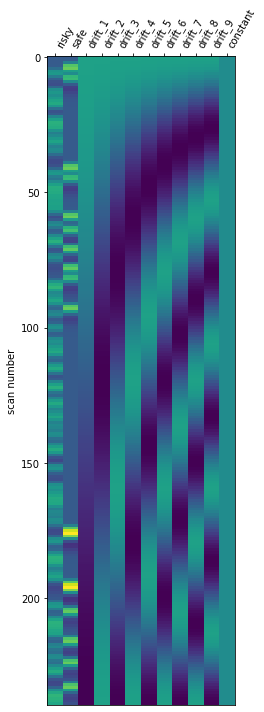

In [9]:
from nilearn.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

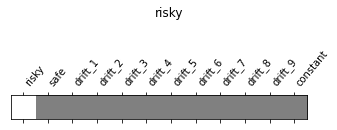

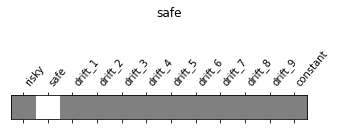

In [10]:
contrasts = make_contrasts(design_matrix)
from nilearn.reporting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=design_matrix)
    plt.suptitle(key)
plt.show()

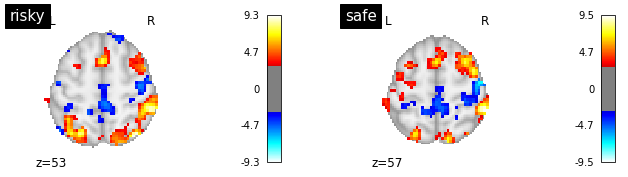

In [11]:
plot_contrast(first_level_model)
plt.show()

one subject, all run

In [15]:
image_samples = layout.derivatives['fMRIPrep'].get(
    subject=subject_id,
    return_type='file',
    suffix='smoothed',
    extension='nii.gz')

event_samples = layout.get(
    subject=subject_id,
    return_type='file',
    suffix='events',
    extension='tsv')

In [16]:
df_events = []

for event_sample in event_samples:
    onsets = pd.read_table(event_sample)
    onsets = onsets[['onset', 'duration', 'respcat']]
    onsets['respcat'] = onsets['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
    onsets.columns = ['onset', 'duration', 'trial_type']
    df_events.append(onsets)

In [17]:
mc = [pd.read_table(confounds)[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']] \
          for confounds in layout.derivatives['fMRIPrep'].get(subject=subject_id, suffix='regressors', extension='.tsv')]

In [18]:
first_level_model = FirstLevelModel(layout.get_tr(), high_pass=.016, hrf_model='glover', noise_model='ols', smoothing_fwhm=6)
first_level_model = first_level_model.fit([nib.load(image_sample) for image_sample in image_samples], events=df_events, confounds=mc)
design_matrix = first_level_model.design_matrices_[0]

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:577: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


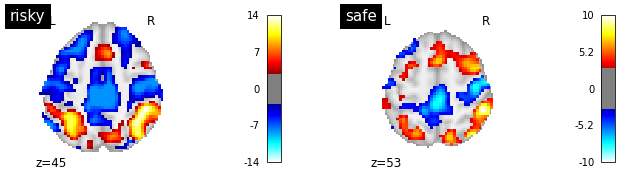

In [19]:
plot_contrast(first_level_model)
plt.show()

all subject, all run for bids format

In [20]:
from nilearn.glm.first_level import first_level_from_bids

models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
    data_dir, 'mixedgamblestask', 'MNI152NLin2009cAsym', smoothing_fwhm=6.0, derivatives_folder='derivatives/fmriprep')

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:850: UserWarning: SliceTimingRef not found in file /home/mybirth0407/datasets/ds000005/derivatives/fmriprep/sub-01/func/sub-01_task-mixedgamblestask_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  img_specs[0])


In [21]:
# events file preprocessing

for i in range(len(models_events)):
    for j in range(len(models_events[i])):
        onsets = models_events[i][j]
        onsets = onsets[['onset', 'duration', 'respcat']]
        onsets['respcat'] = onsets['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
        onsets.columns = ['onset', 'duration', 'trial_type']
        models_events[i][j] = onsets

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [22]:
# confounds file preprocessing

for i in range(len(models_confounds)):
    for j in range(len(models_confounds[i])):
        mc = models_confounds[i][j]
        mc = mc[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        models_confounds[i][j] = mc

In [ ]:
first_level_models = [models[i].fit([nib.load(image_sample) for image_sample in models_run_imgs[i]], events=models_events[i], confounds=models_confounds[i]) \
                          for i in tqdm(range(len(models)))]

 81%|████████▏ | 13/16 [05:07<01:08, 22.81s/it]

In [ ]:
for i in range(0, 16):
    plot_contrast(first_level_models[i])
    plt.show()